# Computación out-of-core con Dask: aspectos básicos

## Dask y Blaze

Dask es una biblioteca del "ecosistema Blaze" (http://blaze.pydata.org/). Blaze tiene como objetivo extender las interfaces y posibilidades del stack científico de Python para acomodar fuentes externas de datos, computación out-of-core y desacoplamiento del formato de los datos. 

Concretamente, Dask (http://dask.readthedocs.io/en/latest/) tiene como objetivo principal proporcionar a los programadores de pandas/numpy con extensiones para pasar de datasets "que caben en memoria" a datasets "que caben en el disco" (out-of-core) y proporciona también una forma de computación distribuida en clusters "de tamaño moderado". 

El concepto principal de Dask es el de representar internamente los cómputos como grafos de tareas (que luego se distribuyen mediante schedulers), pero ocultar esa complejidad mediante colecciones a las que los data scientists están acostumbrados:

<img src="http://dask.readthedocs.io/en/latest/_images/collections-schedulers.png">

Por ello, nosotros aquí vemos Dask como usuarios. Los desarrolladores de Dask son los que re-implementan algoritmos mediante un API diferente.

## Instalación

Se puede instalar Dask mediante conda, pip u otros mecanismos:

http://dask.readthedocs.io/en/latest/install.html

## Programación estilo NumPy con Dask

Se puede utilizar los arrays de Dask de manera similar a los de NumPy. Vamos a crear primero un array de ejemplo y guardarlo en un fichero HDF5.

In [1]:
!rm -f datos_sensor.hdf5

import numpy as np
import dask.array as da
ndatos = 1000000
niter = 20
for i in range(1, niter):
    # Generamos un array de NumPy y lo convertimos.
    # Nótese que no haría falta para este caso pasar por NumPy
    # dado que podemos utilizar dask.array.random.normal
    x = np.random.randn(ndatos)
    y = da.from_array(x, chunks=(ndatos/100))
    y.to_hdf5('datos_sensor.hdf5', '/reads'+str(i), 
              compression='lzf', shuffle=True) # shuffle intenta optimizar el ratio de compresión.


Hemos creado datos a partir de un array de NumPy y los hemos grabado en un fichero HDF5. Nótese que el patrón anterior nos permite crear arrays pequeños en memoria temporales, y generar un fichero cuyos contenidos no cabrían en memoria. Esto es un tipo de operación "chunked", es decir, por bloques.

Podemos recuperar los datos cuando los necesitemos.

In [2]:
import h5py
f = h5py.File('datos_sensor.hdf5')
dset = f['/reads1']
dset

<HDF5 dataset "reads1": shape (1000000,), type "<f8">

Todavía no están en memoria. Podemos recuperarlos si el tamaño es menor que la memoria, o recuperarlos parcialmente (con slicing).

In [3]:
dset[...]

array([-0.44695222,  0.47933304, -0.00398707, ...,  0.9945652 ,
        1.49248619, -0.99120752])

Si tenemos en el disco un array de un tamaño que no cabe en memoria, podríamos calcular la suma de sus elementos utilizando simplemente NumPy, implementando una operación secuencial que toma los datos en fragmentos. En nuestro caso, podríamos hacerlo tomando los diferentes arrays en disco, pero con slicing podríamos tomar "trozos" de una array en disco igualmente.

In [4]:
sumas = []
for i in range(1, niter):
    chunk = f['/reads'+str(i)]
    sumas.append(np.sum(chunk))
print(sum(sumas))

2376.38713244


Nótese que la ejecución anterior es **secuencial**, pero podría hacerse paralela, esta es una de las cosas que hace Dask. Nótese también que muchos algoritmos sobre grandes datos se pueden descomponer y paralelizar de forma similar, piénsese por ejemplo en la multiplicación de matrices.

La decisión de cómo se agrupan (chunks) los datos es importante para la eficiencia, pero no hay fórmulas mágicas para determinarlo. Algunas directrices pueden ser las siguientes:

* Debe ser suficientemente pequeño para que entre bien en memoria, ya que puede haber varios chunks en memoria a la vez.
* Debe ser suficientemente grande para que los cálculos sobre el chunk tarden más que el overhead de aprox. 1ms que se incurre al planificar el cálculo. 
* Los chunks deberían alinearse con el tipo de cálculo que se vaya a realizar. Por ejemplo, si se van a sumar dos arrays, conviene que tengan el mismo tamaño de chunk.



Normalmente los chunks son de un tamaño relativamente grande, varios MB. En los ejemplos que utilizamos aquí son pequeños solo a modo ilustrativo.

Una vez hecho lo anterior, podemos leer los diferentes datos en un array mucho más grande, que ya es un array de Dask que puede estar en disco o incluso distribuido.

In [5]:
data = [da.from_array(f['/reads'+str(i)], chunks=(ndatos/100)) for i in range(1, niter)] 
data

[dask.array<array-e..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-9..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-7..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-c..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-c..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-3..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-e..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-7..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-8..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-3..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-f..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-2..., shape=(1000000,), dtype=float64, chunksize=(10000,)>,
 dask.array<array-9..., shape=(1000000,), dtype=float64, chunksi

In [6]:
gran_array = da.concatenate(data, axis=0)
gran_array.shape

(19000000,)

Ahora ya se puede tratar como un array de NumPy. Nótese que cuando se utiliza por ejemplo una función o una expresión como la siguiente, no se hace ningún cálculo. 

In [7]:
media = gran_array.mean() + 2*gran_array.std()
media

dask.array<add-715..., shape=(), dtype=float64, chunksize=()>

El cálculo solo se lleva a cabo cuando se solicita explícitamente. Es decir, Dask actúa de forma perezosa (lazy).

In [8]:
media.compute()

2.0001301849080506

## Grafos de computación

La idea de Dask es ocultarnos la optimización del cálculo que se hace "por debajo". Si tenemos instalada la herramienta Graphviz (http://www.graphviz.org/) y la biblioteca Python para graphviz en nuestro ordenador podemos verlos.

In [9]:
import graphviz

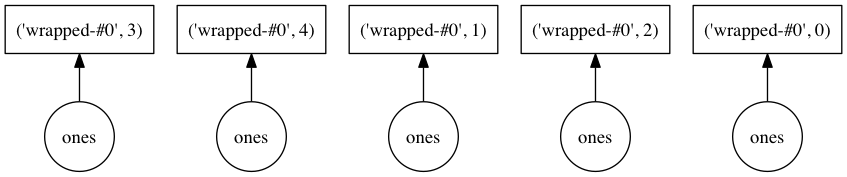

In [10]:
ones = da.ones(25, chunks=(5,))
ones._visualize()

Realmente el array no es tal en este momento, es un grafo, en el que se especifican las operaciones para crear ese array. Podemos añadir operaciones adicionales y el grafo con los pasos se completa.

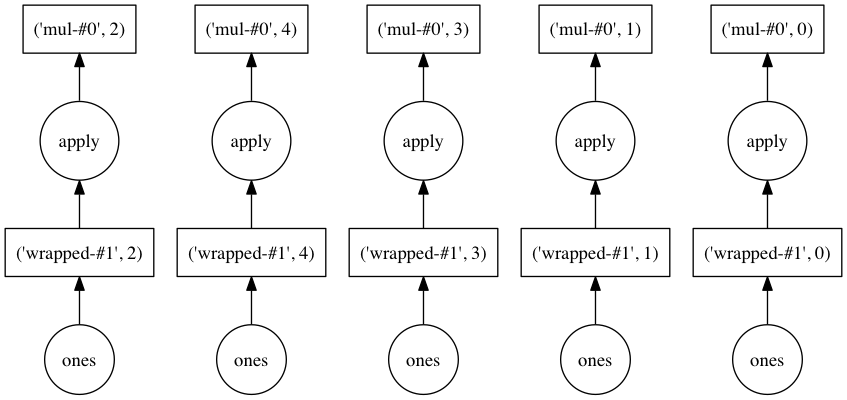

In [11]:
(ones*2)._visualize()

Cuando las operaciones son de reducción, se producen valores de tamaño menor como se refleja a continuación, y Dask decide la optimización a realizar.

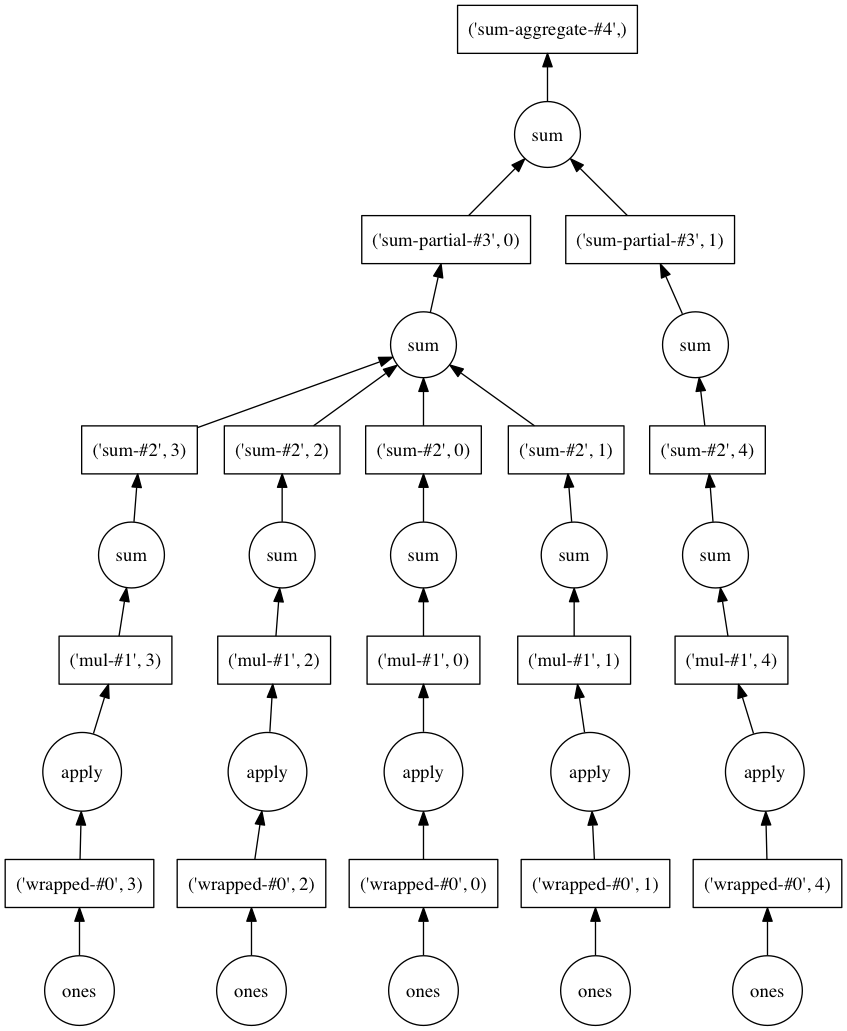

In [12]:
(ones*2).sum()._visualize()

Esto se aplica también a los slices y a las matrices. Por ejemplo.

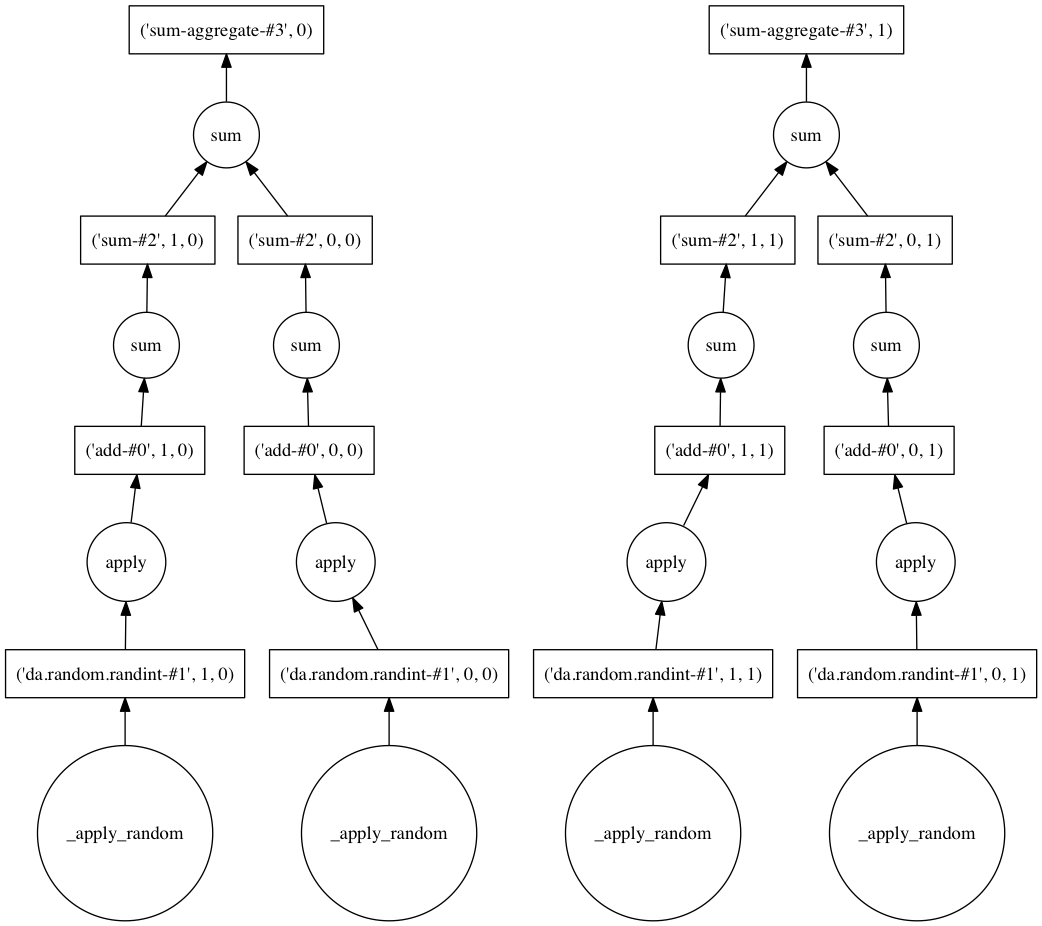

In [13]:
x = da.random.randint(0, 100, size=(10, 6), chunks=(5,5))
c = (x+1).sum(axis=0)
c._visualize()

In [14]:
c.compute()

array([592, 570, 526, 495, 580, 480])

Los grafos son acíclicos pero pueden tener operaciones sobre fragmentos calculados anteriormente.

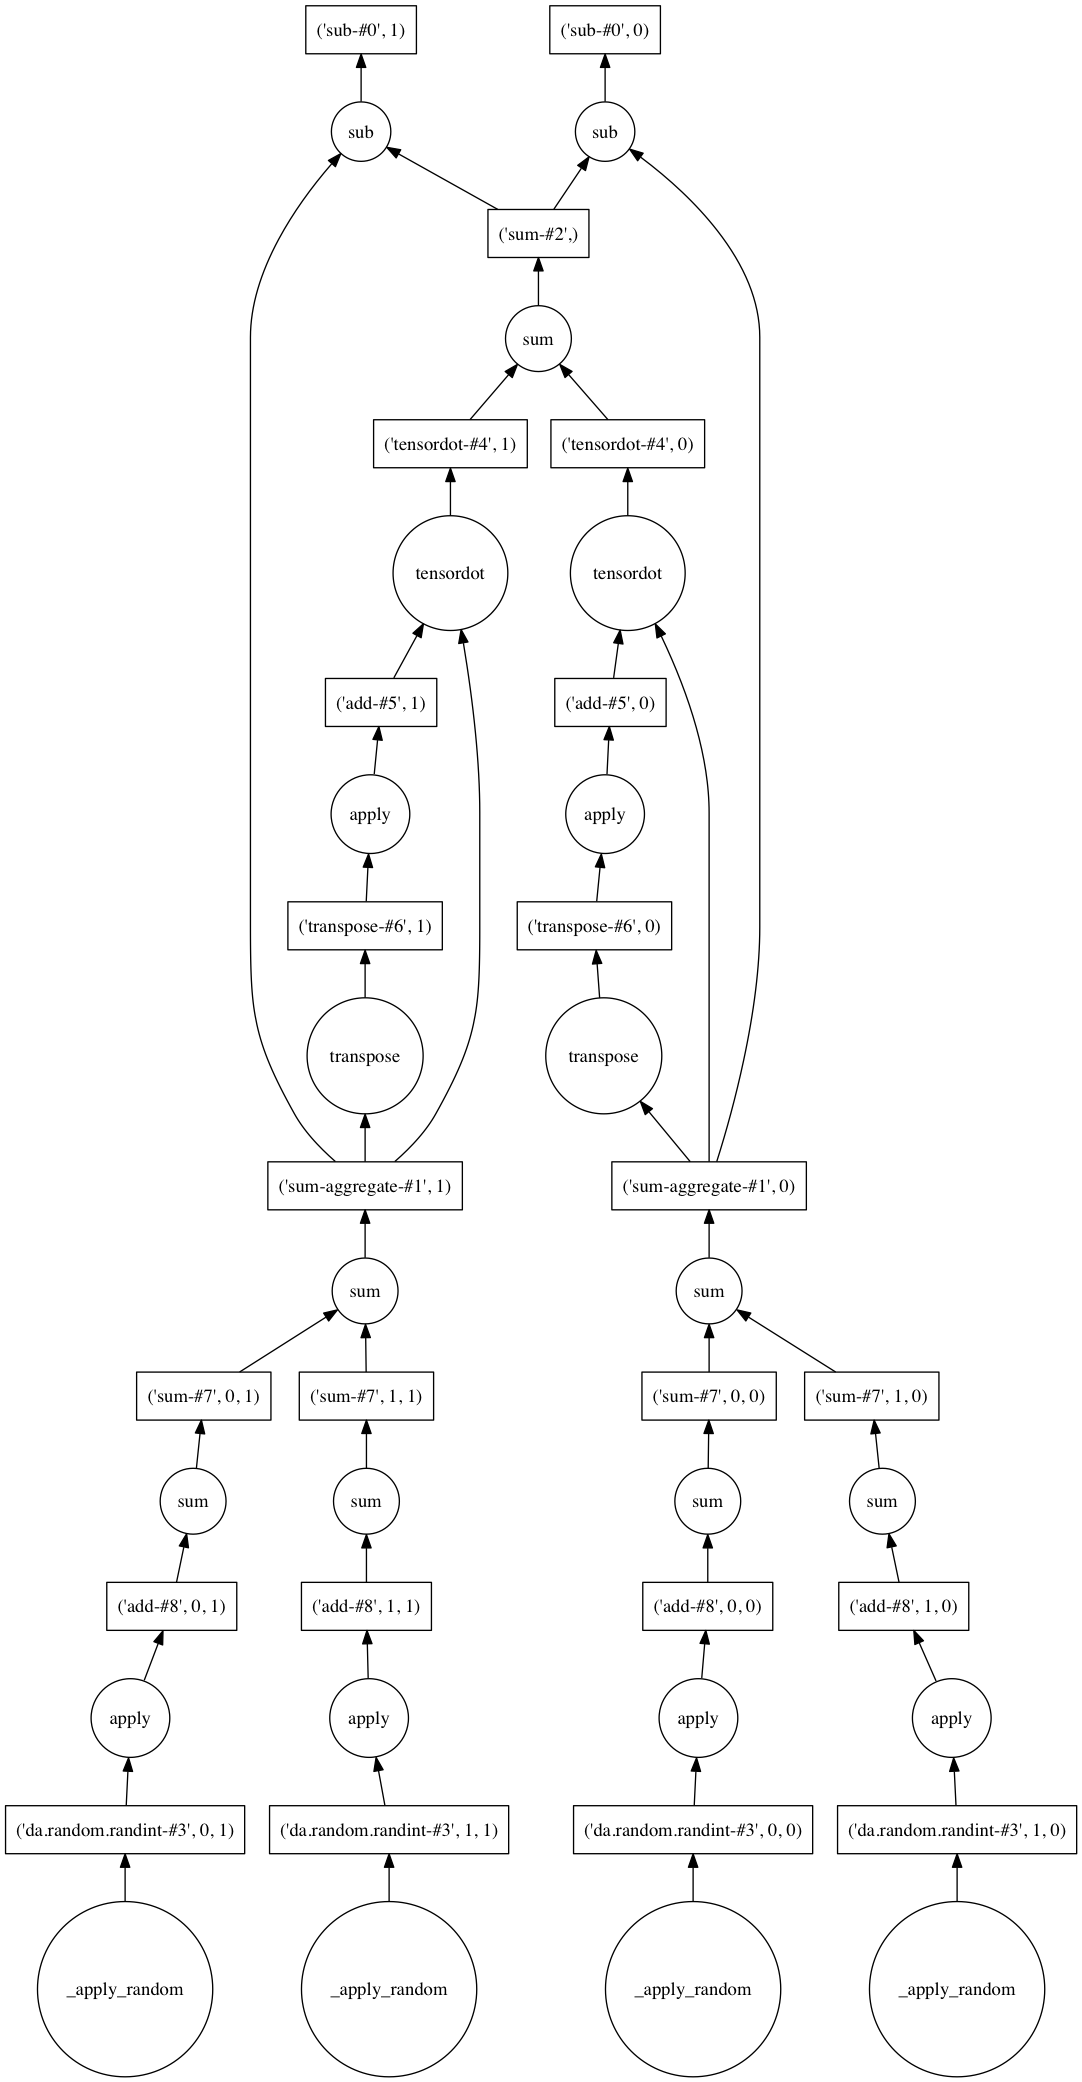

In [15]:
(c.dot(c.T+2)-c)._visualize()

## Paralelismo con Dask

Cuando es posible, Dask utiliza múltiples hilos de ejecución que pueden hacer uso de la capacidad de procesamiento paralelo de los microprocesadores.

In [16]:
%%time
n = 10000
x = np.random.normal(10, 0.2, size=(n,n))
y = x.mean(axis=0)

CPU times: user 4.67 s, sys: 544 ms, total: 5.21 s
Wall time: 5.58 s


In [17]:
%%time
n = 10000
x = da.random.normal(10, 0.2, size=(n,n), chunks=(1000, 1000))
y = x.mean(axis=0).compute()

CPU times: user 6.73 s, sys: 717 ms, total: 7.45 s
Wall time: 2.71 s


Nótese en los ejemplos anteriores que el tiempo consumido de CPU es mayor con Dask, pero el tiempo total es menor. Esto es una indicación de ejecución en paralelo.

No obstante, el comportamiento anterior es muy dependiente del tamaño de chunk, por ejemplo si lo hacemos mucho más pequeño el *overhead* del paralelismo hace que la ejecución sea más lenta.

In [18]:
%%time
n = 10000
x = da.random.normal(10, 0.2, size=(n,n), chunks=(100, 100))
y = x.mean(axis=0).compute()

CPU times: user 13.8 s, sys: 3.47 s, total: 17.3 s
Wall time: 10.1 s


## Un vistazo a la parte interna

Podemos utilizar Dask como se utiliza NumPy sin preocuparnos de cómo funciona internamente. Pero si queremos entender algo más de su funcionamiento, podemos explorar cómo se representan los datos internamente.

Concretamente, Dask representa los cálculos como un diccionario de tareas. Los argumentos son claves en el diccionario o literales. Las llamadas a función se representan con tuplas.

In [24]:
from dask.threaded import get
def add(x,y):
    return x + y

dsk = { 'a' : 1,
        'b' : 2,
        'c' : (add, 'a', 'b')}

get(dsk, 'c')

3

Podemos ver la representación interna de los datos de ejemplos anteriores. 

In [25]:
(ones*2).dask

{('mul-aed787489c0191273c071b9e2c713d04', 0): (<function apply>,
  <function dask.array.core.partial_by_order>,
  [('wrapped-df4d946f2043b3889e6de9657883728c', 0)],
  {'function': <function operator.mul>, 'other': [(1, 2)]}),
 ('mul-aed787489c0191273c071b9e2c713d04', 1): (<function apply>,
  <function dask.array.core.partial_by_order>,
  [('wrapped-df4d946f2043b3889e6de9657883728c', 1)],
  {'function': <function operator.mul>, 'other': [(1, 2)]}),
 ('mul-aed787489c0191273c071b9e2c713d04', 2): (<function apply>,
  <function dask.array.core.partial_by_order>,
  [('wrapped-df4d946f2043b3889e6de9657883728c', 2)],
  {'function': <function operator.mul>, 'other': [(1, 2)]}),
 ('mul-aed787489c0191273c071b9e2c713d04', 3): (<function apply>,
  <function dask.array.core.partial_by_order>,
  [('wrapped-df4d946f2043b3889e6de9657883728c', 3)],
  {'function': <function operator.mul>, 'other': [(1, 2)]}),
 ('mul-aed787489c0191273c071b9e2c713d04', 4): (<function apply>,
  <function dask.array.core.par

## Programación estilo DataFrame con Dask

Dask también proporciona capacidades para trabajar al estilo de los DataFrames de pandas. Realmente, un dataframe de Dask internamente serán varios. Algunas de esas particiones pueden no estar en memoria sino en disco hasta que sea necesario utilizarlas. Por eso, el uso de operaciones **sobre un índice** son mucho más eficientes que si utilizamos una columna. 

Es importante entender que al leer por ejemplo los datos, la interfaz es muy similar a pandas, pero incluye funciones adicionales, y no hace la lectura en ese momento, sino cuando es necesario para hacer algún cómputo.

In [20]:
import dask.dataframe as dd

df = dd.read_csv('noaa/*.txt', usecols= ["WBAN", "AvgTemp", "AvgMaxTemp", "AvgMinTemp", "TotalSnowfall", "TotalMonthlyPrecip"], 
                 na_values=["T"," T", " T ","M"])

Y como en el caso de los arrays, las expresiones no se evalúan hasta el momento en que se pide explícitamente.

In [28]:
mean = df["AvgMaxTemp"].mean()
mean

dd.Scalar<series-..., dtype=float64>

In [29]:
mean.compute()

63.27705428899462

En el ejemplo anterior, no hay una partición del dataframe, por lo tanto las *divisiones* no están realizadas.

In [42]:
df.divisions

(None, None, None, None, None, None, None)

Al usar un índice, se hacen divisiones del dataframe sobre el índice, Dask inenta dividirlo en fragmentos aproximadamente iguales.

In [46]:
df.set_index("WBAN").divisions

(102, 3102, 4925, 14974, 26516, 92816, 96404)

Se pueden utilizar también las capacidades de pandas de indexación, slicing y agrupamiento, entre otras.

In [40]:
exp = df[(df.AvgTemp>mean) & (df.TotalMonthlyPrecip>0)]
exp

dd.DataFrame<getitem..., npartitions=6>

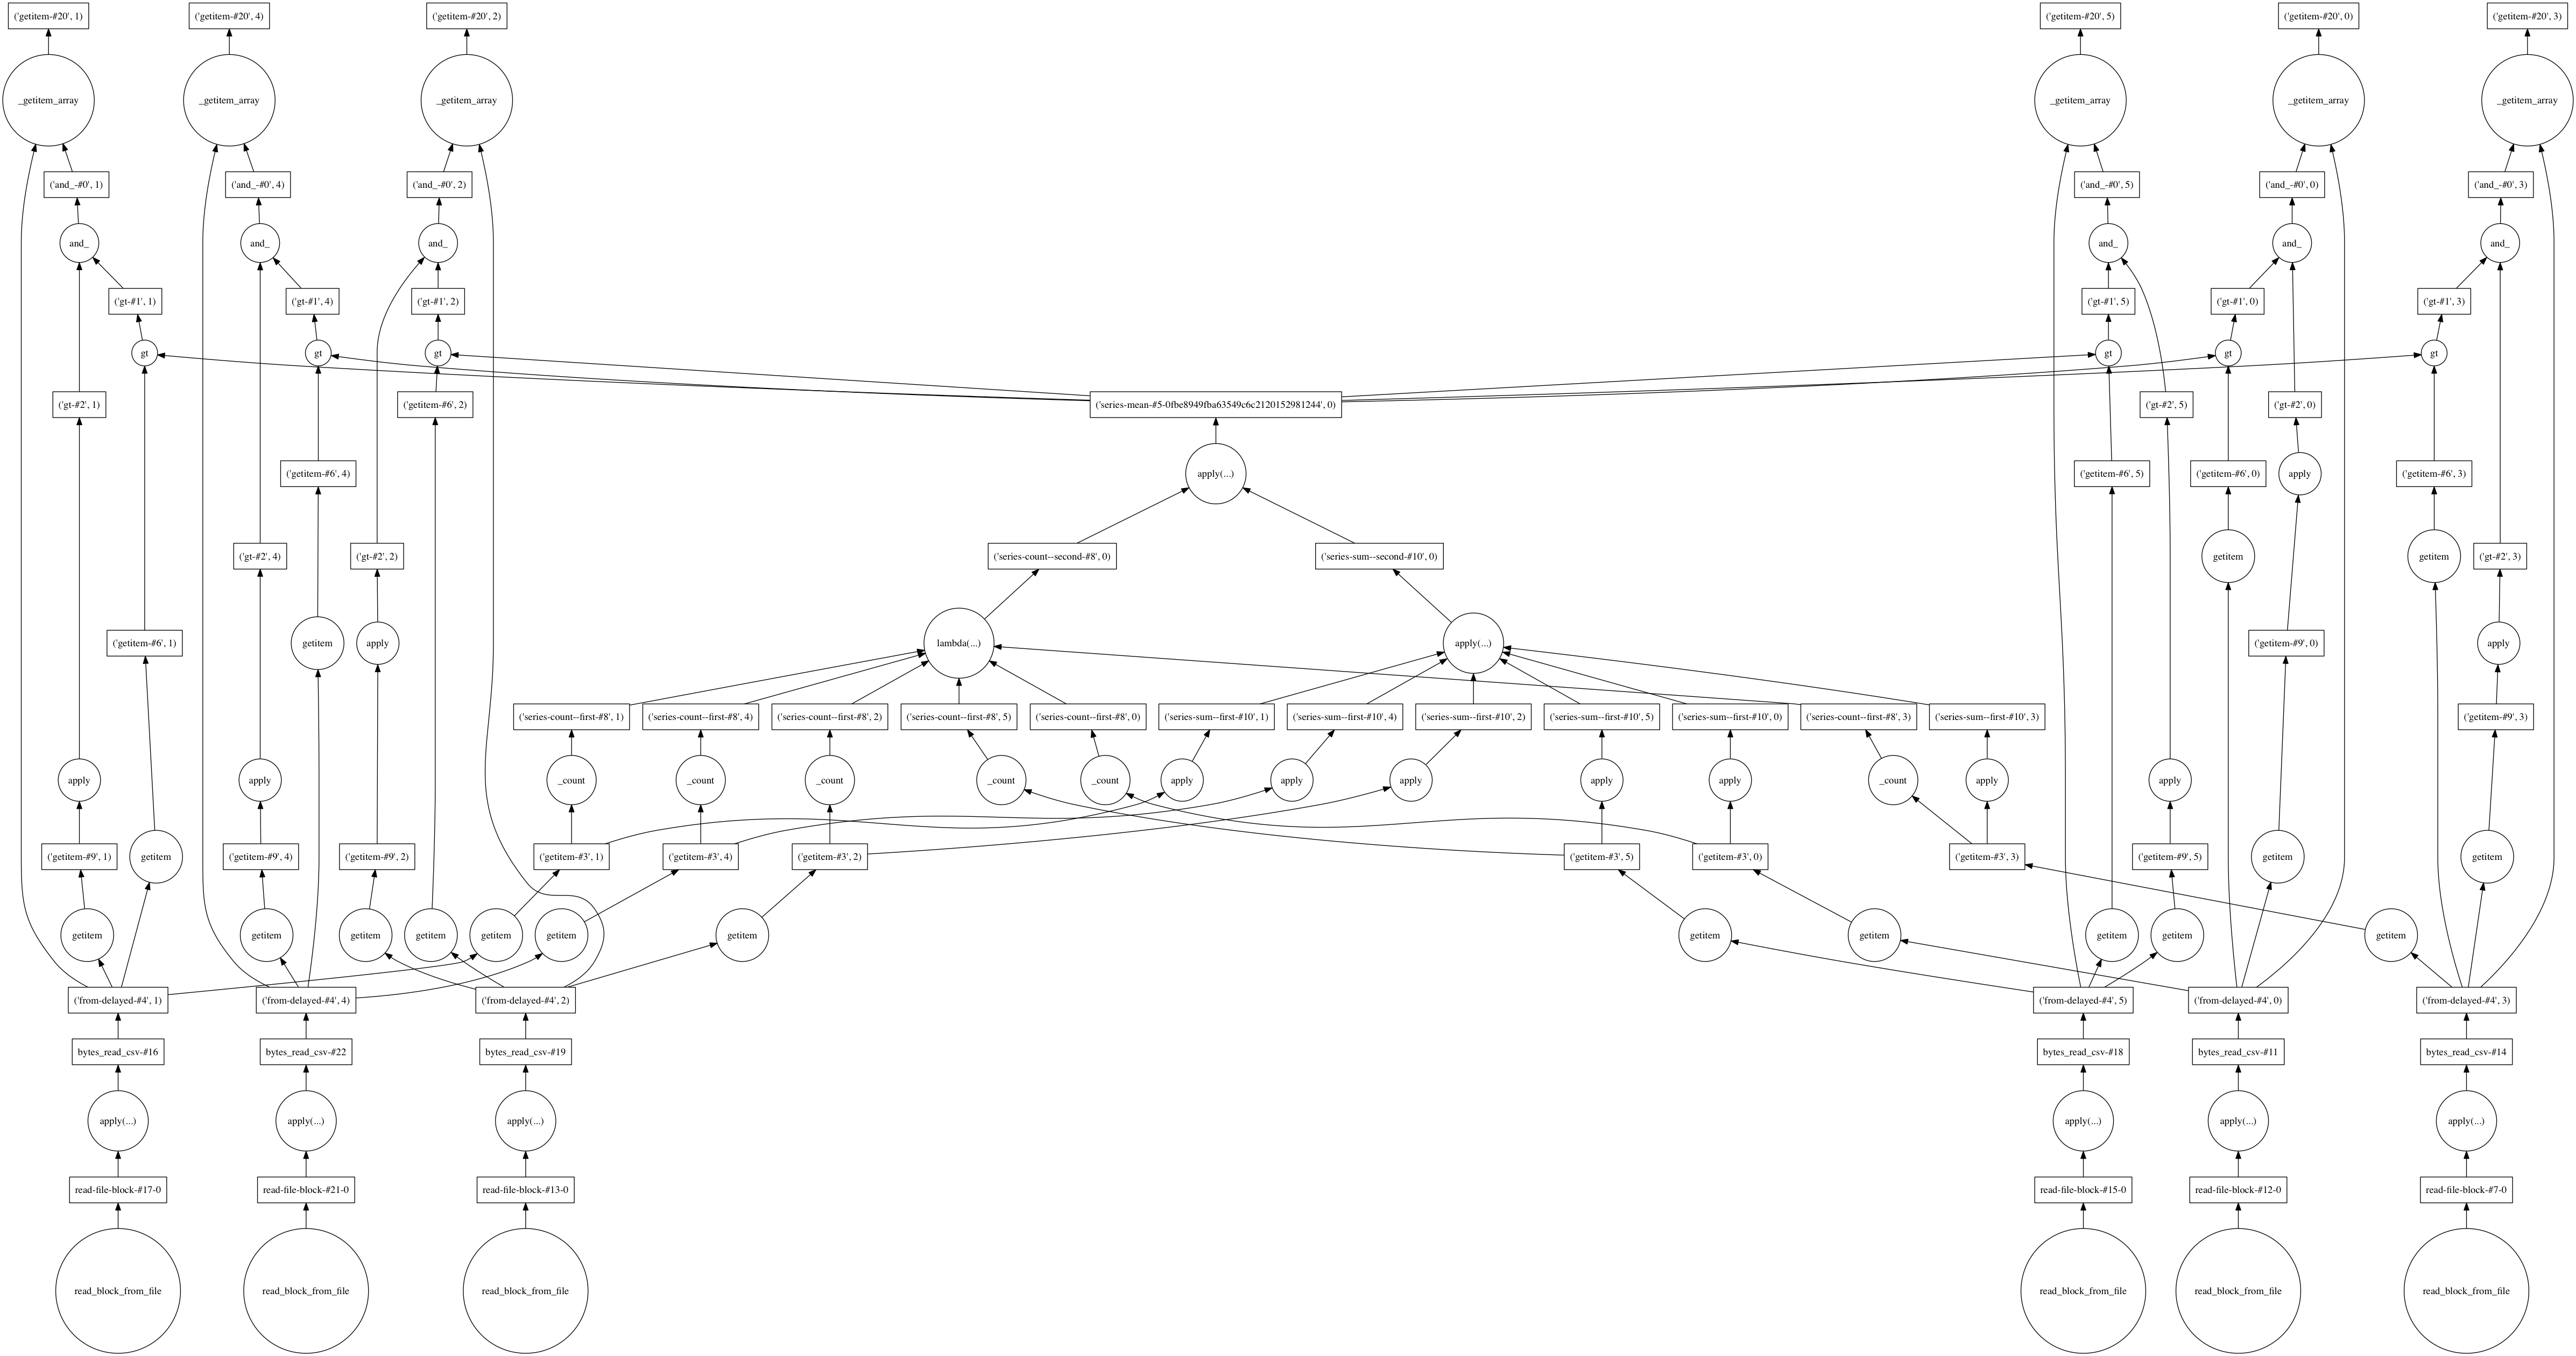

In [41]:
exp._visualize()

In [35]:
df[(df.AvgTemp>mean) & (df.TotalMonthlyPrecip>0)].compute().head(5)

,WBAN,AvgMaxTemp,AvgMinTemp,AvgTemp,TotalMonthlyPrecip,TotalSnowfall
710,11624,85.4,72.2,78.8,0.50,NaN
711,11630,83.6,71.0,77.3,1.27,NaN
713,11640,84.0,73.4,78.7,1.63,NaN
714,11641,84.4,72.9,78.7,1.60,NaN
729,12836,72.6,63.3,68.0,1.48,NaN


En ocasiones podemos crear expresiones complejas por pasos, que no se ejecutan hasta la llamada a compute(), y al ser el resultado de esa expresión un dataframe o array "pequeño", éste ya se puede tratar en memoria.

In [36]:
bystation = df.groupby("WBAN")
bystation

In [37]:
means = bystation.mean().dropna().compute()
means.head(5)

,AvgMaxTemp,AvgMinTemp,AvgTemp,TotalMonthlyPrecip,TotalSnowfall
WBAN,,,,,
3024,72.150000,46.083333,59.150000,1.362000,0.000
3856,70.933333,48.950000,59.983333,3.785000,0.300
13739,60.775000,42.750000,51.775000,3.211667,2.150
13874,71.033333,51.500000,61.266667,3.736667,0.075
13877,65.233333,41.383333,53.333333,2.265000,9.200


/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


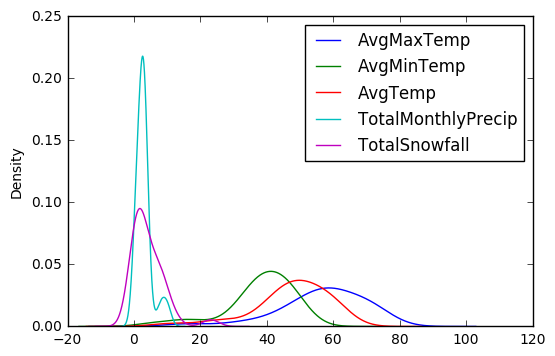

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
means.plot(kind="kde")